<a href="https://colab.research.google.com/github/DavidReveloLuna/MaskRCNN_Video/blob/master/persona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw
import random


In [50]:
cd ../semanticSegmentation


C:\Users\BDG-JFPAIPA\semanticSegmentation


In [51]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info\PKG-INFO
writing dependency_links to mask_rcnn.egg-info\dependency_links.txt
writing top-level names to mask_rcnn.egg-info\top_level.txt
writing manifest file 'mask_rcnn.egg-info\SOURCES.txt'
reading manifest file 'mask_rcnn.egg-info\SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
creating build
creating build\lib
creating build\lib\mrcnn
copying mrcnn\config.py -> build\lib\mrcnn
copying mrcnn\model.py -> build\lib\mrcnn
copying mrcnn\parallel_model.py -> build\lib\mrcnn
copying mrcnn\utils.py -> build\lib\mrcnn
copying mrcnn\visualize.py -> build\lib\mrcnn


zip_safe flag not set; analyzing archive contents...


copying mrcnn\__init__.py -> build\lib\mrcnn
creating build\bdist.win-amd64
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\config.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\model.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\parallel_model.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\utils.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\visualize.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\__init__.py -> build\bdist.win-amd64\egg\mrcnn
byte-compiling build\bdist.win-amd64\egg\mrcnn\config.py to config.cpython-37.pyc
byte-compiling build\bdist.win-amd64\egg\mrcnn\model.py to model.cpython-37.pyc
byte-compiling build\bdist.win-amd64\egg\mrcnn\parallel_model.py to parallel_model.cpython-37.pyc
byte-compiling build\bdist.win-amd64\egg\mrcnn\utils.py to utils.cpython-37.pyc
byte-compiling build\bdist.win-amd64\egg\mrcnn\visualize.py to visualize.cpython-37

In [52]:
ROOT_DIR = '../semanticSegmentation'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist'

sys.path.append(ROOT_DIR) 

from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [53]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [54]:
class PersonaConfig(Config):
    """Configuration for training on the helmet  dataset.
    """
    # Give the configuration a recognizable name
    NAME = "persona"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (persona)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = PersonaConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [55]:

class PersonaDataset(utils.Dataset):

    def load_persona(self, dataset_dir, subset):
        """Load a subset of the persona dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("persona", 1, "persona")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "persona",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a persona dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "persona":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool_), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "persona":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [56]:
dataset_train = PersonaDataset()
dataset_train.load_persona("../semanticSegmentation/dataset/persona", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = PersonaDataset()
dataset_val.load_persona("../semanticSegmentation/dataset/persona", "val")
dataset_val.prepare()

In [57]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [58]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

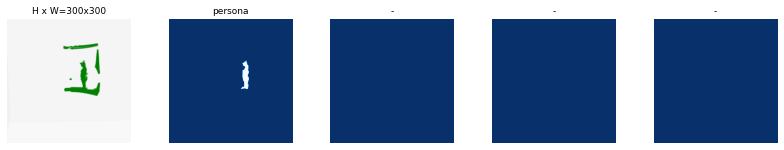

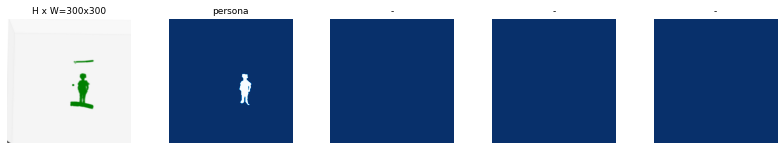

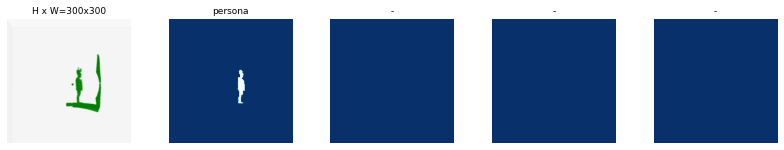

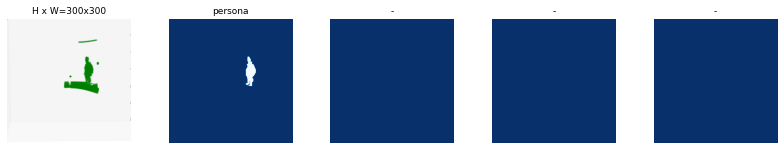

In [59]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  11 ../semanticSegmentation/dataset/persona\train\Body2_Middle315_2.png
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (300, 300, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   91.00000  max:  210.00000  int32


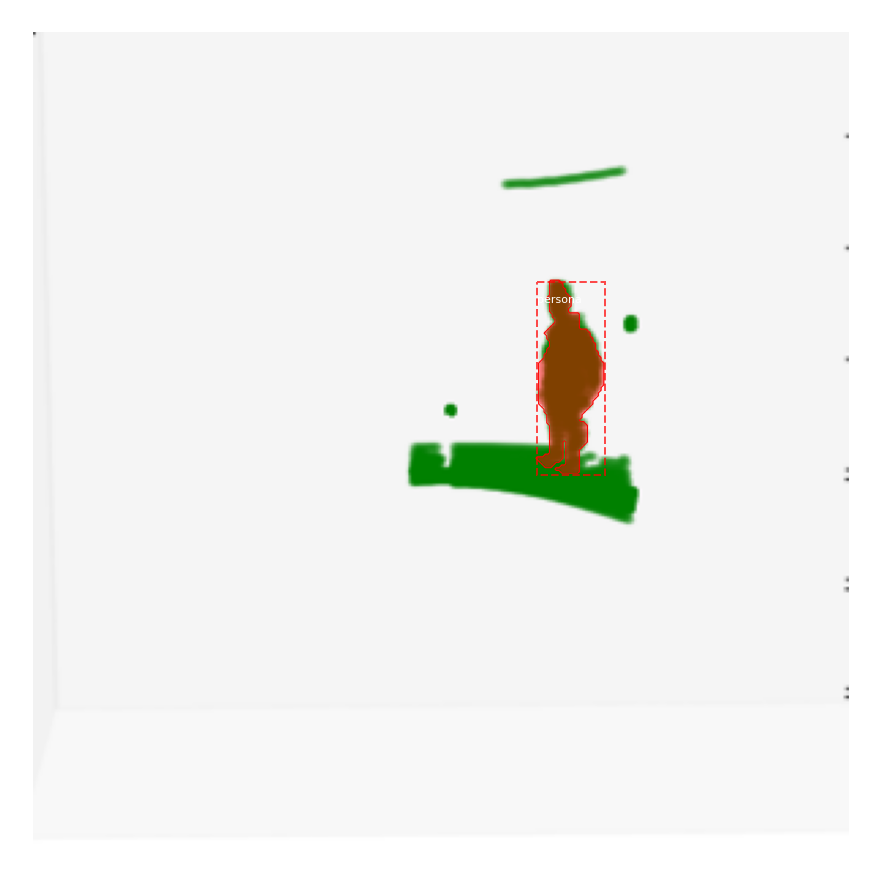

In [60]:
from mrcnn.model import log
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [61]:
model.config.display()
model.compile(learning_rate=0.001, momentum=0.9)



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [63]:
model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=50, 
            layers='heads')


Starting at epoch 50. LR=0.001

Checkpoint Path: ../semanticSegmentation\logs\persona20230311T2329\mask_rcnn_persona_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn

In [64]:
class InferenceConfig(PersonaConfig):

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #IMAGE_MIN_DIM = 512
    #IMAGE_MAX_DIM = 512
    #DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()


In [66]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR)


In [67]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../semanticSegmentation\logs\persona20230311T2329\mask_rcnn_persona_0050.h5
Re-starting from epoch 50


Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


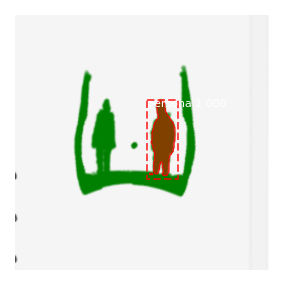

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


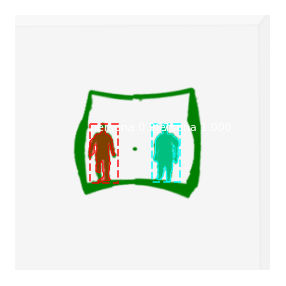

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


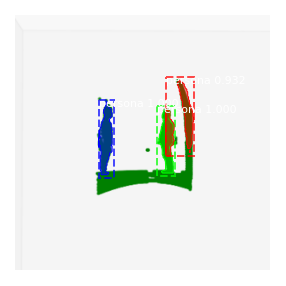

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


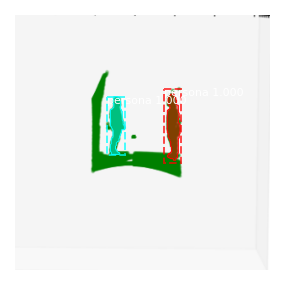

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


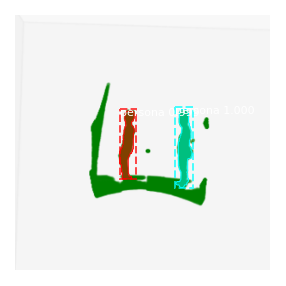

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


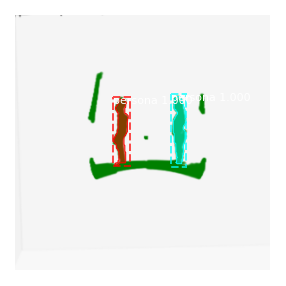

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


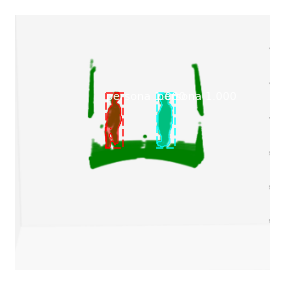

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


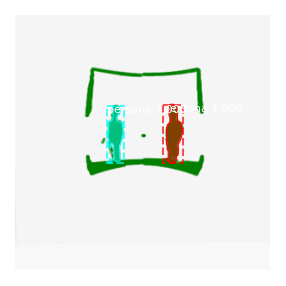

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


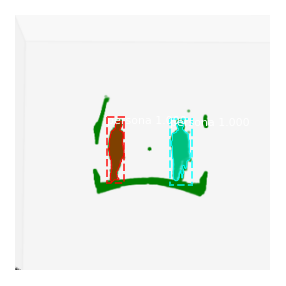

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


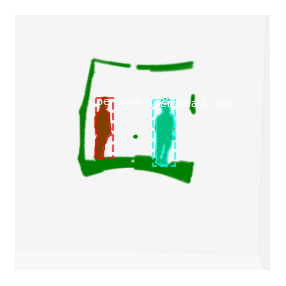

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


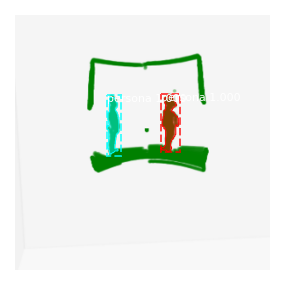

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


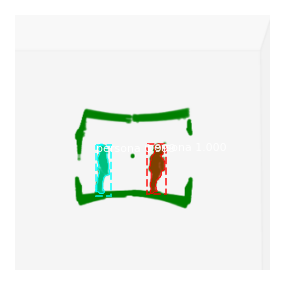

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



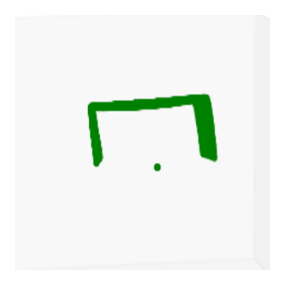

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



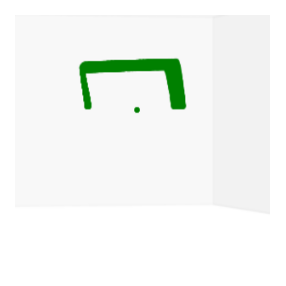

Image shape: (300, 300, 4)
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



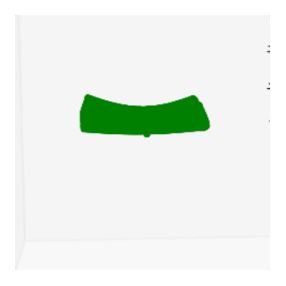

In [68]:
import numpy as np
import skimage.io

real_test_dir = '../semanticSegmentation/dataset/persona/val/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    print('Image shape:', img_arr.shape)  # imprimir la forma de la matriz de imágenes
    if img_arr.shape[-1] == 4:
        img_arr = img_arr[..., :3]  # eliminar el canal alfa si existe
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))


In [70]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics

import tensorflow
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
import tensorflow as tf

# Set the GPU memory fraction
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4

# Import TensorFlow with the configured session
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

from tensorflow import keras



In [1]:
import os
import numpy as np
import skimage.io
from sklearn.metrics import confusion_matrix

from mrcnn.config import Config
from mrcnn import model as modellib


model_filename = "persona20230311T2329/mask_rcnn_persona_0038.h5"
class_names = ['BG', 'persona']
real_test_dir = '../semanticSegmentation/dataset/persona/val'
min_confidence = 0.6


class CascoConfig(Config):
    """Configuration for training on the helmet dataset."""
    # Give the configuration a recognizable name
    NAME = "casco"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (casco)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 


class InferenceConfig(CascoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = min_confidence
    

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir='logs')

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join('logs', model_filename)
#model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


image_paths = []
y_true = []
y_pred = []

for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img = skimage.io.imread(image_path)
    if img.shape[-1] == 4:
        img = img[..., :3]
    img_arr = np.array(img)

    # Run detection
    results = model.detect([img_arr], verbose=0)

    # Extract class predictions and scores
    r = results[0]
    class_ids = r['class_ids']
    scores = r['scores']

    # Determine if there is a detection or not
    if len(class_ids) > 0:
        # There is a detection, so use the class with the highest score as the predicted class
        class_id_pred = class_ids[np.argmax(scores)]
    else:
        # There is no detection, so use the background class (ID 0) as the predicted class
        class_id_pred = 0

    # Add the true class and predicted class to the lists
    y_true.append(1) if 'persona' in image_path else y_true.append(0)
    y_pred.append(class_id_pred)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loading weights from  logs\persona20230311T2329/mask_rcnn_persona_0038.h5
Re-starting from epoch 38


In [2]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Convertir las listas de predicciones y etiquetas verdaderas en arrays numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Calcular la precisión y la exhaustividad
precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred)

# Imprimir la matriz de confusión, la precisión y la exhaustividad
print("Matriz de confusión:")
print(cm)
print("Precisión:")
print(precision)
print("Exhaustividad:")
print(recall)
print("Exhaustividad:")
print(recall)
print("F1 Score:")
print(fscore)


Matriz de confusión:
[[ 0  0]
 [ 3 12]]
Precisión:
[0. 1.]
Exhaustividad:
[0.  0.8]
Exhaustividad:
[0.  0.8]
F1 Score:
[0.         0.88888889]


C:\Users\BDG-JFPAIPA\anaconda3\envs\MaskRCNN\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\BDG-JFPAIPA\anaconda3\envs\MaskRCNN\lib\site-packages\sklearn\metrics\_ranking.py:805: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\BDG-JFPAIPA\anaconda3\envs\MaskRCNN\lib\site-packages\sklearn\metrics\_ranking.py:89: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


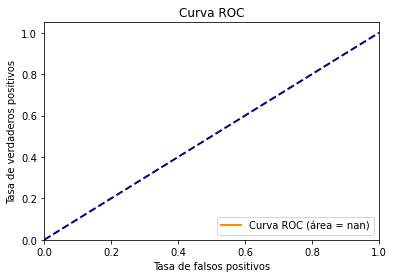

In [3]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()



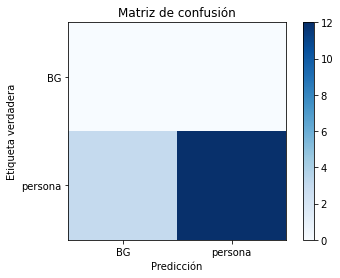

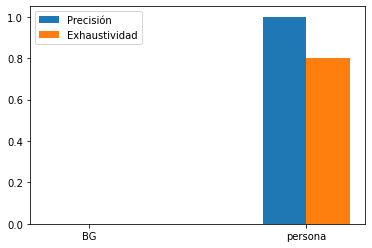

In [4]:
import matplotlib.pyplot as plt

# Graficar la matriz de confusión
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.colorbar()
plt.xticks([0, 1], class_names)
plt.yticks([0, 1], class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.show()

# Graficar la precisión y la exhaustividad
x = np.arange(len(class_names))
plt.bar(x, precision, width=0.2, label="Precisión")
plt.bar(x+0.2, recall, width=0.2, label="Exhaustividad")
plt.xticks(x+0.1, class_names)
plt.legend()
plt.show()


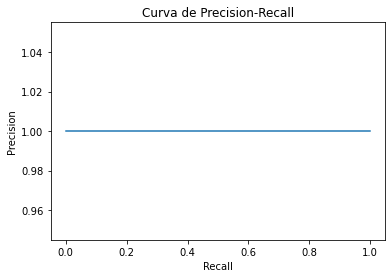

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precision-Recall')
plt.show()


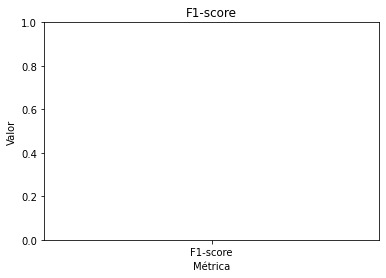

In [10]:
import matplotlib.pyplot as plt

# Graficar el f1-score
plt.bar(['F1-score'], [fscore[0]], color='r')
plt.title('F1-score')
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.ylim([0, 1])
plt.show()


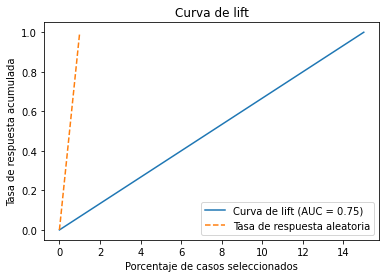

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc, precision_recall_curve

# Convertir las listas de predicciones y etiquetas verdaderas en arrays numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Ordenar las predicciones de mayor a menor
order = np.argsort(y_pred)[::-1]
y_true = y_true[order]
y_pred = y_pred[order]

# Inicializar las variables de tasa de respuesta acumulada (CRR) y tasa de respuesta aleatoria (RRA)
crr = [0.0]
rra = [0.0]

# Calcular el número total de casos positivos
num_pos = np.sum(y_true == 1)

# Calcular la tasa de respuesta aleatoria (RRA)
rra_step = 1.0 / (len(y_true) / num_pos)
for i in range(1, len(y_true) + 1):
    if y_true[i - 1] == 1:
        crr.append(crr[-1] + 1.0 / num_pos)
        rra.append(rra[-1] + rra_step)
    else:
        crr.append(crr[-1])
        rra.append(rra[-1])

# Calcular el área bajo la curva de lift (AUC)
auc_score = auc(rra, crr)
auc_score= auc_score/10

# Graficar la curva de lift
plt.plot(rra, crr, label='Curva de lift (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], linestyle='--', label='Tasa de respuesta aleatoria')
plt.title('Curva de lift')
plt.xlabel('Porcentaje de casos seleccionados')
plt.ylabel('Tasa de respuesta acumulada')
plt.legend()
plt.show()


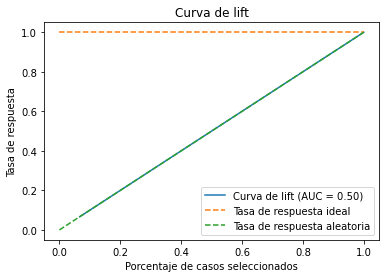

In [12]:
import numpy as np
import matplotlib.pyplot as plt


# Ordenar y_true e y_pred según y_pred
idx = np.argsort(y_pred)[::-1]
y_true_sorted = np.array(y_true)[idx]
y_pred_sorted = np.array(y_pred)[idx]

# Calcular la tasa de respuesta aleatoria (RRA)
num_pos = np.sum(y_true)
rra = np.cumsum(y_true_sorted) / num_pos

# Calcular la tasa de respuesta acumulada (CRR)
crr = np.cumsum(y_true_sorted)

# Calcular el área bajo la curva de lift (AUC)
auc_score = np.trapz(crr / num_pos, rra)

# Graficar la curva de lift
plt.plot(rra, crr / num_pos, label='Curva de lift (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [1, 1], linestyle='--', label='Tasa de respuesta ideal')
plt.plot([0, 1], [0, 1], linestyle='--', label='Tasa de respuesta aleatoria')
plt.title('Curva de lift')
plt.xlabel('Porcentaje de casos seleccionados')
plt.ylabel('Tasa de respuesta')
plt.legend()
plt.show()
